# Shape Analysis of Cancer Cells

Lead author: Nina Miolane.

This notebook studies *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy. 

This analysis relies on the *elastic metric between discrete curves* from Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

This notebook is adapted from Florent Michel's submission to the [ICLR 2021 Computational Geometry and Topology challenge](https://github.com/geomstats/challenge-iclr-2021).

<center>
    <img src="figures/cells_image.png" width=600px />
</center>

Figure 1: Representative images of the cell lines using fluorescence microscopy, studied in this notebook (Image credit : Ashok Prasad). The cells nuclei (blue), the actin cytoskeleton (green) and the lipid membrane (red) of each cell are stained and colored. We only focus on the cell shape in our analysis.

# 1. Introduction and Motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology [(MGCKCKDDRTWSBCC2018)](#References). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells allow accurate classification and discrimination between cancer cell lines treated with different drugs [(AXCFP2019)](#References).

As metrics defined on the shape space of curves, the *elastic metrics* [(SKJJ2010)](#References) implemented in Geomstats are a potential tool for analyzing and comparing biological cell shapes. Their associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing cell shapes.

In [1]:
from decimal import Decimal
import matplotlib.pyplot as plt

import geomstats.backend as gs
import numpy as np
from nsimplices import *
from common import *
import scipy.stats as stats
from sklearn import manifold

gs.random.seed(2021)

In [2]:
base_path = "/home/wanxinli/dyn/dyn/"
data_path = os.path.join(base_path, "datasets")

dataset_name = 'osteosarcoma'
figs_dir = os.path.join("/home/wanxinli/dyn/dyn/saved_figs", dataset_name)
rescale = True
print(f"Will save figs to {figs_dir}")

Will save figs to /home/wanxinli/dyn/dyn/saved_figs/osteosarcoma


# 2. Dataset Description

We study a dataset of mouse *Osteosarcoma* imaged cells [(AXCFP2019)](#References). The dataset contains two different cancer cell lines : *DLM8* and *DUNN*, respectively representing a more agressive and a less agressive cancer.  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a *control* cell (no treatment), or has been treated with one of the following drugs : *Jasp* (jasplakinolide) and *Cytd* (cytochalasin D).

Each cell comes from a raw image containing a set of cells, which was thresholded to generate binarized images.

<td>
    <img src="figures/binarized_cells.png" width=400px />
</td>

After binarizing the images, contouring was used to isolate each cell, and to extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. We load these discrete curves into the notebook.

In [3]:
import geomstats.datasets.utils as data_utils

cells, lines, treatments = data_utils.load_cells()
print(lines)
print(treatments)
print(f"Total number of cells : {len(cells)}")

['dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dlm8', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn', 'dunn',

The cells are grouped by treatment class in the dataset : 
- the *control* cells, 
- the cells treated with *Cytd*,
- and the ones treated with *Jasp*. 

Additionally, in each of these classes, there are two cell lines : 
- the *DLM8* cells, and
- the *DUNN* ones.

Before using the dataset, we check for duplicates in the dataset.

We compute the pairwise distance between two cells. If the pairwise distance is smaller than 0.1, we visualize the corresponding cells to check they are duplicates.

In [4]:
tol = 1e-1
for i, cell_i in enumerate(cells):
    for j, cell_j in enumerate(cells):
        if i != j and cell_i.shape[0] == cell_j.shape[0]:
            dist = np.sum(np.sqrt(np.sum((cell_i-cell_j)**2,axis=1)))
            if dist < tol:
                print(f"cell indices are: {i} and {j}, {lines[i]}, {lines[j]}, {treatments[i]}, {treatments[j]}")

cell indices are: 363 and 396, dlm8, dlm8, cytd, cytd
cell indices are: 396 and 363, dlm8, dlm8, cytd, cytd
cell indices are: 513 and 519, dlm8, dlm8, jasp, jasp
cell indices are: 519 and 513, dlm8, dlm8, jasp, jasp


Text(0.5, 1.0, 'Cell 396')

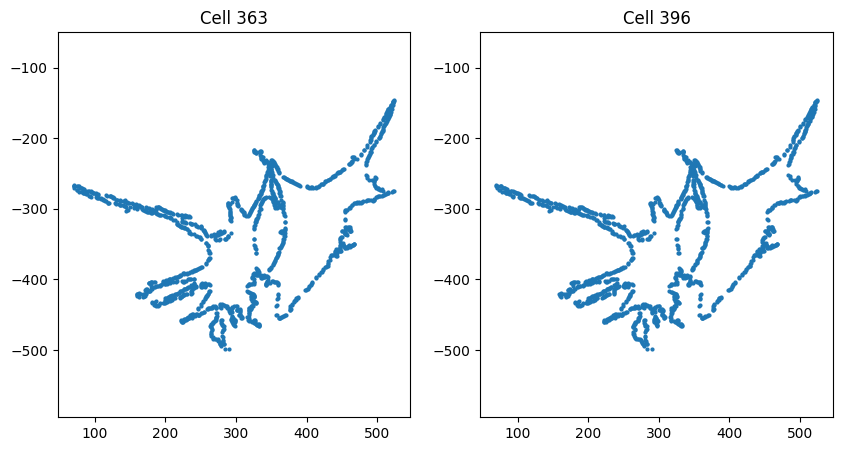

In [5]:
pair_indices = [363, 396]

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(121)
index_0 = pair_indices[0]
plt.scatter(cells[index_0][:, 0], cells[index_0][:, 1], s=4)
plt.axis("equal")
plt.title(f"Cell {index_0}")

fig.add_subplot(122)
index_1 = pair_indices[1]
plt.scatter(cells[index_1][:, 0], cells[index_1][:, 1], s=4)
plt.axis("equal")
plt.title(f"Cell {index_1}")

Text(0.5, 1.0, 'Cell 519')

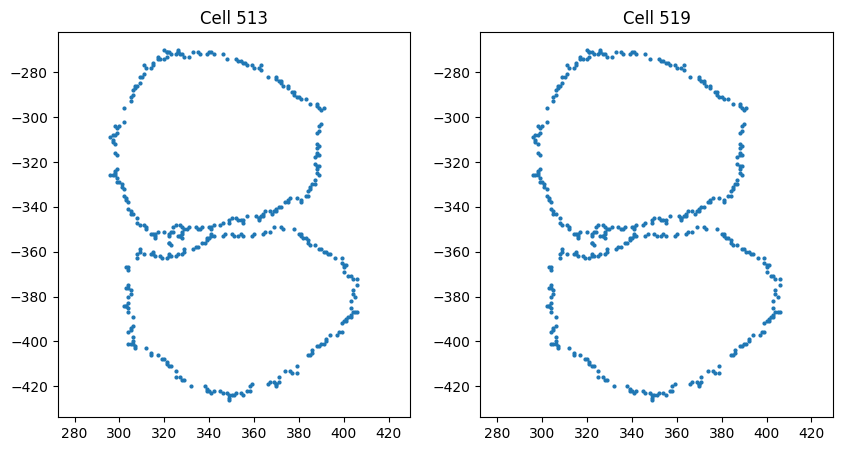

In [6]:
pair_indices = [513, 519]

fig = plt.figure(figsize=(10, 5))
fig.add_subplot(121)
index_0 = pair_indices[0]
plt.scatter(cells[index_0][:, 0], cells[index_0][:, 1], s=4)
plt.axis("equal")
plt.title(f"Cell {index_0}")

fig.add_subplot(122)
index_1 = pair_indices[1]
plt.scatter(cells[index_1][:, 0], cells[index_1][:, 1], s=4)
plt.axis("equal")
plt.title(f"Cell {index_1}")

Check the category indices in order to remove corresponding cells in `ds_align`

In [7]:
delete_indices = [363, 396, 513, 519]
category_count = {}
global_count = 0
for i in range(len(cells)):
    treatment = treatments[i]
    line = lines[i]
    if treatment not in category_count:
        category_count[treatment] = {}
    if line not in category_count[treatment]:
        category_count[treatment][line] = 0
    if global_count in delete_indices:
        print(treatment, line, category_count[treatment][line])
    category_count[treatment][line] += 1
    global_count += 1


cytd dlm8 45
cytd dlm8 78
jasp dlm8 20
jasp dlm8 26


Since 363th, 396th and 513th, 519th are duplicates of each other and after visualization we see they are poor quality cells with overlapping adjacent cells, we remove them from our dataset. 

In [8]:
def remove_cells(cells, lines, treatments, delete_indices):
    """ 
    Remove cells of control group from cells, lines and treatments

    :param list[int] delete_indices: the indices to delete
    """
    delete_indices = sorted(delete_indices, reverse=True) # to prevent change in index when deleting elements
    
    # Delete elements
    cells = del_arr_elements(cells, delete_indices)
    lines = list(np.delete(np.array(lines), delete_indices, axis=0))
    treatments = list(np.delete(np.array(treatments), delete_indices, axis=0))

    return cells, lines, treatments

In [9]:
delete_indices = [363, 396, 513, 519]
cells, lines, treatments = remove_cells(cells, lines, treatments, delete_indices)
print(len(cells), len(lines), len(treatments))

646 646 646


This is shown by displaying the unique elements in the lists `treatments` and `lines`:

In [10]:
import pandas as pd

TREATMENTS = gs.unique(treatments)
print(TREATMENTS)
LINES = gs.unique(lines)
print(LINES)
METRICS = ['SRV', 'Linear']

['control' 'cytd' 'jasp']
['dlm8' 'dunn']


The size of each class is displayed below:

In [11]:
ds = {}

n_cells_arr = gs.zeros((3, 2))

for i, treatment in enumerate(TREATMENTS):
    print(f"{treatment} :")
    ds[treatment] = {}
    for j, line in enumerate(LINES):
        to_keep = gs.array(
            [
                one_treatment == treatment and one_line == line
                for one_treatment, one_line in zip(treatments, lines)
            ]
        )
        ds[treatment][line] = [
            cell_i for cell_i, to_keep_i in zip(cells, to_keep) if to_keep_i
        ]
        nb = len(ds[treatment][line])
        print(f"\t {nb} {line}")
        n_cells_arr[i, j] = nb

n_cells_df = pd.DataFrame({"dlm8": n_cells_arr[:, 0], "dunn": n_cells_arr[:, 1]})
n_cells_df = n_cells_df.set_index(TREATMENTS)

display(n_cells_df)
# display(ds)

control :
	 114 dlm8
	 204 dunn
cytd :
	 80 dlm8
	 93 dunn
jasp :
	 60 dlm8
	 95 dunn


,dlm8,dunn
control,114.0,204.0
cytd,80.0,93.0
jasp,60.0,95.0


We have organized the cell data into the dictionnary `ds`. Before proceeding to the actual data analysis, we provide an auxiliary function `apply_func_to_ds`.

In [12]:
def apply_func_to_ds(input_ds, func):
    """Apply the input function func to the input dictionnary input_ds.

    This function goes through the dictionnary structure and applies
    func to every cell in input_ds[treatment][line].

    It stores the result in a dictionnary output_ds that is returned
    to the user.

    Parameters
    ----------
    input_ds : dict
        Input dictionnary, with keys treatment-line.
    func : callable
        Function to be applied to the values of the dictionnary, i.e.
        the cells.

    Returns
    -------
    output_ds : dict
        Output dictionnary, with the same keys as input_ds.
    """
    output_ds = {}
    for treatment in TREATMENTS:
        output_ds[treatment] = {}
        for line in LINES:
            output_list = []
            for one_cell in input_ds[treatment][line]:
                output_list.append(func(one_cell))
            output_ds[treatment][line] = gs.array(output_list)
    return output_ds

Now we can move on to the actual data analysis, starting with a preprocessing of the cell boundaries.

# 3. Preprocessing 

### Interpolation: Encoding Discrete Curves With Same Number of Points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

To set up the number of sampling points, you can edit the following line in the next cell:

In [13]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length / nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index) * (
            curve[(index + 1) % old_length] - curve[index]
        )
        pos += incr
    return interpolation


k_sampling_points = 2000

To illustrate the result of this interpolation, we compare for a randomly chosen cell the original curve with the correponding interpolated one (to visualize another cell, you can simply re-run the code).

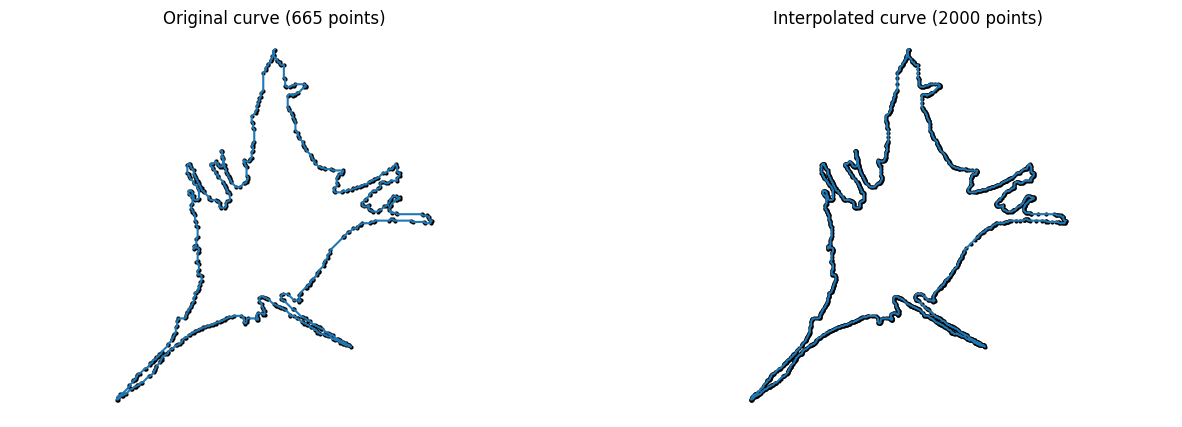

In [14]:
rand = 324
cell_rand = cells[rand]
cell_interpolation = interpolate(cell_rand, k_sampling_points)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.scatter(cell_rand[:, 0], cell_rand[:, 1], color='black', s=4)

plt.plot(cell_rand[:, 0], cell_rand[:, 1])
plt.axis("equal")
plt.title(f"Original curve ({len(cell_rand)} points)")
plt.axis("off")

fig.add_subplot(122)
plt.scatter(cell_interpolation[:, 0], cell_interpolation[:, 1], color='black', s=4)

plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis("equal")
plt.title(f"Interpolated curve ({k_sampling_points} points)")
plt.axis("off")

plt.savefig(os.path.join(figs_dir, "interpolation.svg"))
plt.savefig(os.path.join(figs_dir, "interpolation.pdf"))

As the interpolation is working as expected, we use the auxiliary function `apply_func_to_ds` to apply the function `func=interpolate` to the dataset `ds`, i.e. the dictionnary containing the cells boundaries.

We obtain a new dictionnary, `ds_interp`, with the interpolated cell boundaries.

In [15]:
ds_interp = apply_func_to_ds(
    input_ds=ds, func=lambda x: interpolate(x, k_sampling_points)
)

The shape of an array of cells in `ds_interp[treatment][cell]` is therefore: `("number of cells in treatment-line", "number of sampling points", 2)`, where 2 refers to the fact that we are considering cell shapes in 2D. 

### Visualization of Interpolated Dataset of Curves

We visualize the curves obtained, for a sample of control cells and treated cells (top row shows control, i.e. non-treated cells; bottom rows shows treated cells) across cell lines (left and blue for dlm8 and right and orange for dunn).

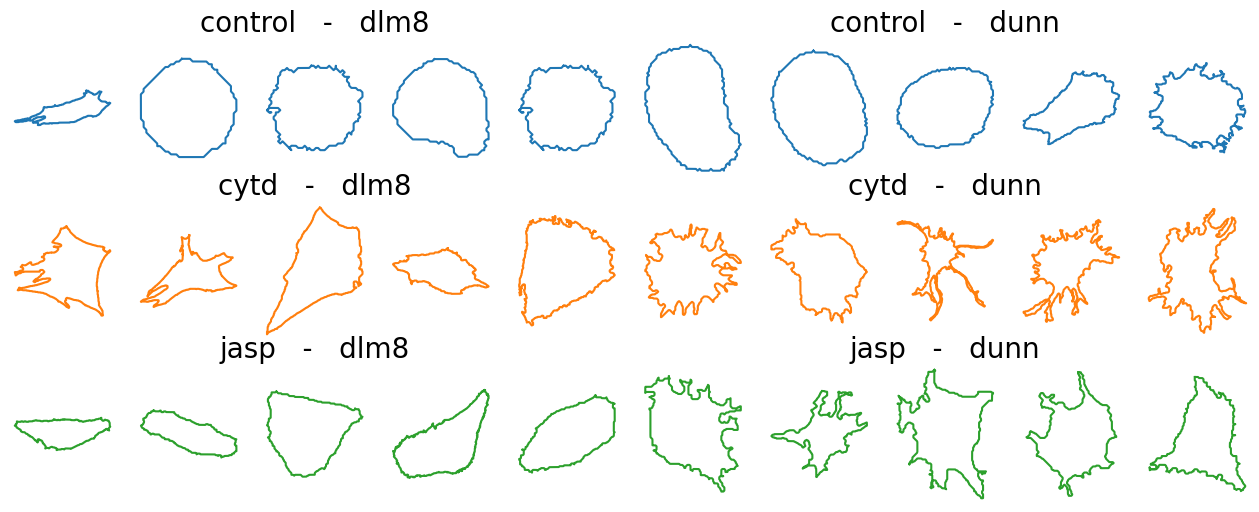

In [16]:
n_cells_to_plot = 5

fig = plt.figure(figsize=(16, 6))
count = 1
for i, treatment in enumerate(TREATMENTS):
    for line in LINES:
        cell_data = ds_interp[treatment][line]
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(cell_data)
            fig.add_subplot(3, 2 * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color="C" + str(i))
            plt.xlim(-170, 170)
            plt.ylim(-170, 170)
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{treatment}   -   {line}", fontsize=20)
# plt.savefig(os.path.join(figs_dir, "sample_cells.svg"))
# plt.savefig(os.path.join(figs_dir, "sample_cells.pdf"))

Visual inspection of these curves seems to indicate more protusions appearing in treated cells, compared with control ones. This is in agreement with the physiological impact of the drugs, which are known to perturb the internal cytoskeleton connected to the cell membrane. Using the elastic metric, our goal will be to see if we can quantitatively confirm these differences.

### Remove duplicate sample points in curves

During interpolation it is likely that some of the discrete curves in the dataset are downsampled from higher number of discrete data points to lower number of data points. Hence, two sampled data points that are close enough may end up overlapping after interpolation and hence such data points have to be dealt with specifically. 

In [17]:
import numpy as np

def preprocess(curve, tol=1e-10):
    """Preprocess curve to ensure that there are no consecutive duplicate points.

    Returns
    -------
    curve : discrete curve
    """

    dist = curve[1:] - curve[:-1]
    dist_norm = np.sqrt(np.sum(np.square(dist), axis=1))

    if np.any( dist_norm < tol ):
        for i in range(len(curve)-1):
            if np.sqrt(np.sum(np.square(curve[i+1] - curve[i]), axis=0)) < tol:
                curve[i+1] = (curve[i] + curve[i+2]) / 2

    return curve

In [18]:
ds_proc = apply_func_to_ds(ds_interp, func=lambda x: preprocess(x))

### Alignment

Our goal is to study the cell boundaries in our dataset, as points in a shape space of closed curves quotiented by translation, scaling, and rotation, so these transformations do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then reparameterize (only for SRV metric).

Since the alignment procedure takes 30 minutes, we ran `osteosarocoma_align.py` and saved the results in `~/dyn/datasets/osteosarcoma/aligned`

Load aligned cells from txt files. These files were generated by calling `align` function in `common.py`.

In [19]:
for treatment in TREATMENTS:
    for line in LINES:
        for metric in METRICS:
            print(f"{treatment} and {line} using {metric}: {len(ds_proc[treatment][line])}")

control and dlm8 using SRV: 114
control and dlm8 using Linear: 114
control and dunn using SRV: 204
control and dunn using Linear: 204
cytd and dlm8 using SRV: 80
cytd and dlm8 using Linear: 80
cytd and dunn using SRV: 93
cytd and dunn using Linear: 93
jasp and dlm8 using SRV: 60
jasp and dlm8 using Linear: 60
jasp and dunn using SRV: 95
jasp and dunn using Linear: 95


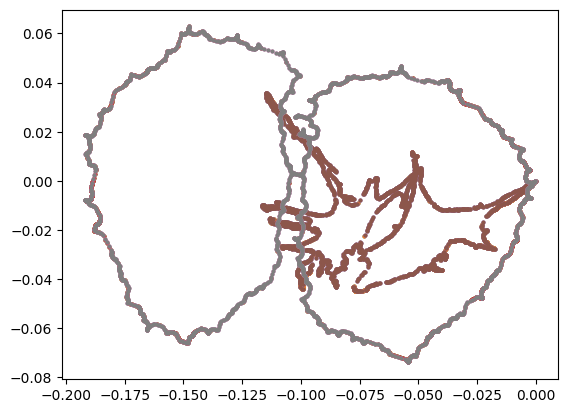

In [20]:
delete_indices = [363, 396, 513, 519]

aligned_base_folder = os.path.join(data_path, dataset_name, "aligned")

ds_align = {}

for metric in METRICS:
    ds_align[metric] = {}
    if metric == 'SRV':
        aligned_folder = os.path.join(aligned_base_folder, 'full')
    elif metric == 'Linear':
        aligned_folder = os.path.join(aligned_base_folder, 'no_reparameterization')
    for treatment in TREATMENTS:
        ds_align[metric][treatment] = {}
        for line in LINES:
            ds_align[metric][treatment][line] = []
            cell_num = len(ds_proc[treatment][line])
            if line == 'dlm8' and (treatment == 'cytd' or treatment == 'jasp'):
                cell_num += 2
            for i in range(cell_num):
                file_path = os.path.join(aligned_folder, f"{treatment}_{line}_{i}.txt")
                cell = np.loadtxt(file_path)

                if (line == 'dlm8' and treatment == 'cytd' and (i == 45 or i == 78)) or \
                    line == 'dlm8' and treatment == 'jasp' and (i == 20 or i == 26):
                    plt.scatter(cell[:, 0], cell[:, 1], s=4)

                else:
                    ds_align[metric][treatment][line].append(cell)

                
            

Check we did not loss any cells after alignment

In [21]:
for treatment in TREATMENTS:
    for line in LINES:
        for metric in METRICS:
            print(f"{treatment} and {line} using {metric}: {len(ds_align[metric][treatment][line])}")

control and dlm8 using SRV: 114
control and dlm8 using Linear: 114
control and dunn using SRV: 204
control and dunn using Linear: 204
cytd and dlm8 using SRV: 80
cytd and dlm8 using Linear: 80
cytd and dunn using SRV: 93
cytd and dunn using Linear: 93
jasp and dlm8 using SRV: 60
jasp and dlm8 using Linear: 60
jasp and dunn using SRV: 95
jasp and dunn using Linear: 95


Visualize reference cell, unaligned cell and aligned cell.

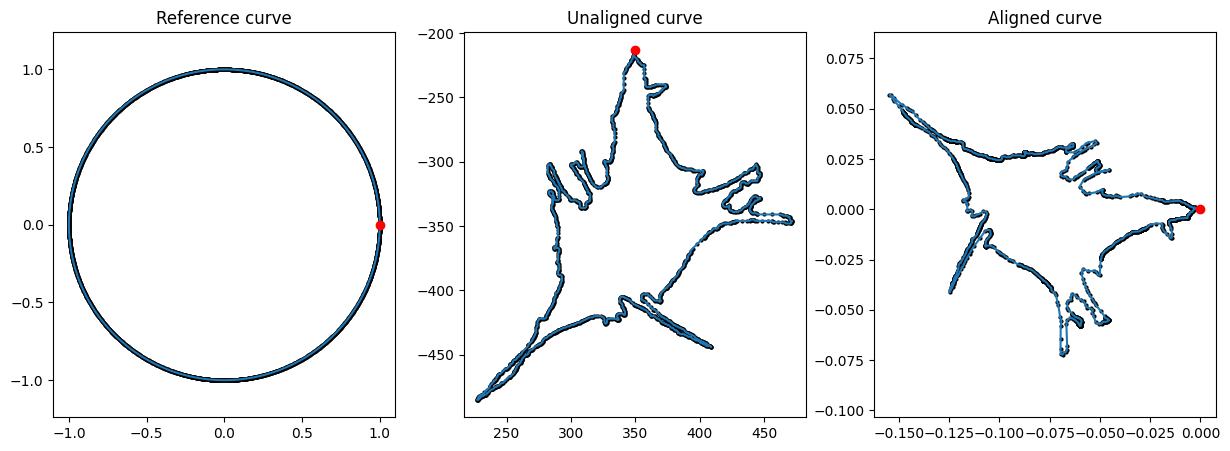

In [22]:
BASE_CURVE = generate_circle_points(k_sampling_points)
index = 6
metric = 'SRV'
unaligned_cell = ds_proc["cytd"]["dlm8"][index]
aligned_cell = ds_align[metric]["cytd"]["dlm8"][index]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot([BASE_CURVE[-1, 0], BASE_CURVE[0, 0]], [BASE_CURVE[-1, 1], BASE_CURVE[0, 1]], 'tab:blue')
plt.scatter(BASE_CURVE[:, 0], BASE_CURVE[:, 1], s=4, c='black')
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.scatter(unaligned_cell[:, 0], unaligned_cell[:, 1], s=4, c='black')
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.scatter(aligned_cell[:, 0], aligned_cell[:, 1], s=4, c='black')
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")

plt.savefig(os.path.join(figs_dir, "alignment.svg"))
plt.savefig(os.path.join(figs_dir, "alignment.pdf"))


In the plot above, the red dot shows the start of the parametrization of each curve. The right curve has been rotated from the curve in the middle, to be aligned with the left (reference) curve, which represents the first cell of the dataset. The starting point (in red) of this right curve has been also set to align with the reference.

# 4 Data Analysis

## Compute Mean Cell Shape of the Whole Dataset: "Global" Mean Shape

We want to compute the mean cell shape of the whole dataset. Thus, we first combine all the cell shape data into a single array.

In [23]:
CURVES_SPACE_SRV = DiscreteCurvesStartingAtOrigin(ambient_dim=2, k_sampling_points=k_sampling_points)

In [24]:
cell_shapes_list = {}
for metric in METRICS:
    cell_shapes_list[metric] = []
    for treatment in TREATMENTS:
        for line in LINES:
            cell_shapes_list[metric].extend(ds_align[metric][treatment][line])

cell_shapes = {}
for metric in METRICS:
    cell_shapes[metric] = gs.array(cell_shapes_list[metric])
print(cell_shapes[metric].shape)

(646, 1999, 2)


Remove outliers using DeCOr-MDS, together for DUNN and DLM8 cell lines.

In [25]:
def linear_dist(cell1, cell2):
    return gs.linalg.norm(cell1 - cell2)

def srv_dist(cell1, cell2):
    CURVES_SPACE_SRV.equip_with_metric(SRVMetric)
    return CURVES_SPACE_SRV.metric.dist(cell1, cell2)
 
# compute pairwise distances
pairwise_dists = {}
metric = 'SRV'
pairwise_dists[metric] = parallel_dist(cell_shapes[metric], srv_dist, k_sampling_points)

metric = 'Linear' 
pairwise_dists[metric] = parallel_dist(cell_shapes[metric], linear_dist, k_sampling_points)



INFO: finding looplift candidates
/home/wanxinli/dyn/dyn/notebooks/common.py:37: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "parallel_dist" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/wanxinli/dyn/dyn/notebooks/common.py (40)

File "common.py", line 40:
def parallel_dist(cells, dist_fun, k_sampling_points):
    <source elided>
    pairwise_dists = np.zeros((cells.shape[0], cells.shape[0]))
    for i in prange(cells.shape[0]):
    ^

  @jit(nopython=False, forceobj=True)


In [26]:
print(pairwise_dists['Linear'].shape)

(646, 646)


In [27]:
# run DeCOr-MDS
metric = 'Linear'
# dim_start = 2 # we know the subspace dimension is 3, we set start and end to 3 to reduce runtime 
# dim_end = 10
dim_start = 3
dim_end = 3
std_multi = 2
subspace_dim, outlier_indices = find_subspace_dim(pairwise_dists[metric], dim_start, dim_end, std_multi)
print(f"subspace dimension is: {subspace_dim}")
print(f"outlier_indices are: {outlier_indices}")

subspace dimension is: 3
outlier_indices are: [  0   1   5   7  26  32  42  56  74  92  95  97  98 113 128 129 134 169
 191 203 305 319 327 329 330 332 334 344 352 356 361 363 364 369 370 372
 374 378 386 390 395 403 420 427 437 438 443 444 451 484 493 495 510 511
 519 525 526 528 529 533 534 535 538 539 540 545 550 554 556 573]


Visualize outlier cells to see if they are artifacts

Text(0.5, -0.01, '')

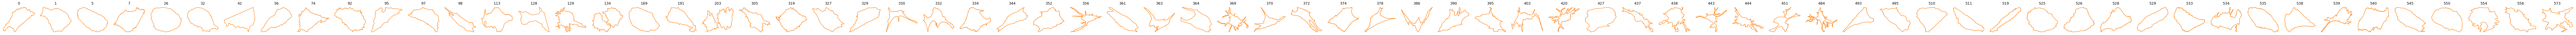

In [28]:
fig, axes = plt.subplots(
    nrows= 1,
    ncols=len(outlier_indices),
    figsize=(2*len(outlier_indices), 2),
)

for i, outlier_index in enumerate(outlier_indices):
    one_cell = cell_shapes[metric][outlier_index]
    ax = axes[i]
    ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j}")
    ax.set_title(f"{outlier_index}", fontsize=14)
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "outlier.svg"))

Text(0.5, -0.01, '')

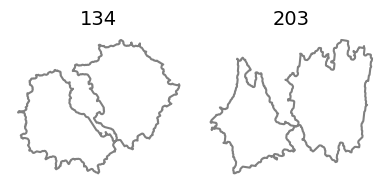

In [29]:
delete_indices = [134, 203]


fig, axes = plt.subplots(
    nrows= 1,
    ncols=len(delete_indices),
    figsize=(2*len(delete_indices), 2),
)


for i, outlier_index in enumerate(delete_indices):
    one_cell = cell_shapes[metric][outlier_index]
    ax = axes[i]
    ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"gray")
    ax.set_title(f"{outlier_index}", fontsize=14)
    # ax.axis("off")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.suptitle(f"", y=-0.01, fontsize=24)
# plt.savefig(os.path.join(figs_dir, "delete_outlier.svg"))
# plt.savefig(os.path.join(figs_dir, "delete_outlier.pdf"))

After visual inspection, we decide to remove the outlier cells

In [30]:
def remove_ds_two_layer(ds, delete_indices):
    global_i = sum(len(v) for values in ds.values() for v in values.values())-1

    for treatment in reversed(list(ds.keys())):
        treatment_values = ds[treatment]
        for line in reversed(list(treatment_values.keys())):
            line_cells = treatment_values[line]
            for i, _ in reversed(list(enumerate(line_cells))):
                if global_i in delete_indices:
                    ds[treatment][line] = np.concatenate((ds[treatment][line][:i], ds[treatment][line][i+1:]), axis=0)
                global_i -= 1
    return ds


def remove_cells_two_layer(cells, cell_shapes, lines, treatments, pairwise_dists, ds_proc, ds_align, delete_indices):
    """ 
    Remove cells of control group from cells, cell_shapes, ds,
    the parameters returned from load_treated_osteosarcoma_cells
    Also update n_cells

    :param list[int] delete_indices: the indices to delete
    """
    delete_indices = sorted(delete_indices, reverse=True) # to prevent change in index when deleting elements
    
    # Delete elements
    cells = del_arr_elements(cells, delete_indices)    
    lines = list(np.delete(np.array(lines), delete_indices, axis=0))
    treatments = list(np.delete(np.array(treatments), delete_indices, axis=0))
    ds_proc = remove_ds_two_layer(ds_proc, delete_indices)
    
    for metric in METRICS:
        cell_shapes[metric] = np.delete(np.array(cell_shapes[metric]), delete_indices, axis=0)
        ds_align[metric] = remove_ds_two_layer(ds_align[metric], delete_indices)
        pairwise_dists[metric] = np.delete(pairwise_dists[metric], delete_indices, axis=0)
        pairwise_dists[metric] = np.delete(pairwise_dists[metric], delete_indices, axis=1)


    return cells, cell_shapes, lines, treatments, pairwise_dists, ds_proc, ds_align

In [31]:
cells, cell_shapes, lines, treatments, pairwise_dists, ds_proc, ds_align = remove_cells_two_layer(cells, cell_shapes, lines, treatments, pairwise_dists, ds_proc, ds_align, delete_indices)

In [32]:
print(len(cells), pairwise_dists['SRV'].shape)
print(cell_shapes['Linear'].shape)
print(len(lines))

644 (644, 644)
(644, 1999, 2)
644


Check we did not loss any other cells after the removal

In [33]:
print(f"cells number is: {len(cells)}, {len(treatments)}, {len(lines)}")

for line in LINES:
    for treatment in TREATMENTS:
        for metric in METRICS:
            print(f"ds_align {line} using {metric}: {len(ds_align[metric][treatment][line])}")
            print(f"ds_proc {line} using {metric}: {len(ds_proc[treatment][line])}")
            print(f"cell_shapes number is : {len(cell_shapes[metric])}")

cells number is: 644, 644, 644
ds_align dlm8 using SRV: 114
ds_proc dlm8 using SRV: 114
cell_shapes number is : 644
ds_align dlm8 using Linear: 114
ds_proc dlm8 using Linear: 114
cell_shapes number is : 644
ds_align dlm8 using SRV: 80
ds_proc dlm8 using SRV: 80
cell_shapes number is : 644
ds_align dlm8 using Linear: 80
ds_proc dlm8 using Linear: 80
cell_shapes number is : 644
ds_align dlm8 using SRV: 60
ds_proc dlm8 using SRV: 60
cell_shapes number is : 644
ds_align dlm8 using Linear: 60
ds_proc dlm8 using Linear: 60
cell_shapes number is : 644
ds_align dunn using SRV: 202
ds_proc dunn using SRV: 202
cell_shapes number is : 644
ds_align dunn using Linear: 202
ds_proc dunn using Linear: 202
cell_shapes number is : 644
ds_align dunn using SRV: 93
ds_proc dunn using SRV: 93
cell_shapes number is : 644
ds_align dunn using Linear: 93
ds_proc dunn using Linear: 93
cell_shapes number is : 644
ds_align dunn using SRV: 95
ds_proc dunn using SRV: 95
cell_shapes number is : 644
ds_align dunn usin

We compute the mean cell shape by using the SRV metric defined on the space of curves' shapes. The space of curves' shape is a manifold: we use the Frechet mean, associated to the SRV metric, to get the mean cell shape.

In [34]:
from geomstats.learning.frechet_mean import FrechetMean

metric = 'SRV'
mean = FrechetMean(CURVES_SPACE_SRV)
mean.fit(cell_shapes[metric])

mean_estimate = mean.estimate_

In [35]:
mean_estimate_aligned = {}

mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
mean_estimate_aligned[metric] = (
    mean_estimate_clean - gs.mean(mean_estimate_clean, axis=0)
)


Also we compute the linear mean

In [36]:
metric = 'Linear'
linear_mean_estimate = gs.mean(cell_shapes[metric], axis=0)
linear_mean_estimate_clean = linear_mean_estimate[~gs.isnan(gs.sum(linear_mean_estimate, axis=1)), :]

mean_estimate_aligned[metric] =  (
    linear_mean_estimate_clean - gs.mean(linear_mean_estimate_clean, axis=0)
)

Plot SRV mean cell versus linear mean cell

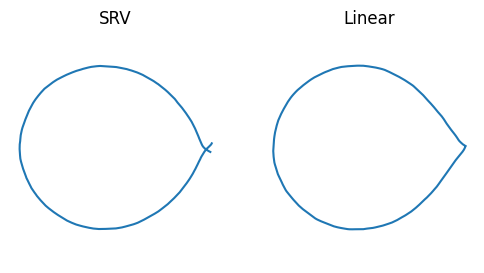

In [37]:
fig = plt.figure(figsize=(6, 3))

fig.add_subplot(121)
metric = 'SRV'
plt.plot(mean_estimate_aligned[metric][:, 0], mean_estimate_aligned[metric][:, 1])
plt.axis("equal")
plt.title("SRV")
plt.axis("off")

fig.add_subplot(122)
metric = 'Linear'
plt.plot(mean_estimate_aligned[metric][:, 0], mean_estimate_aligned[metric][:, 1])
plt.axis("equal")
plt.title("Linear")
plt.axis("off")

plt.savefig(os.path.join(figs_dir, "global_mean.svg"))
plt.savefig(os.path.join(figs_dir, "global_mean.pdf"))



# Analyze Distances to the "Global"  Mean Shape

We consider each of the subgroups of cells, defined by their treatment and cell line. We wish to study how far each of this group is from the global mean shape. We compute the list of distances to the global mean shape.

In [38]:
metric = 'SRV'
dists_to_global_mean = {}
dists_to_global_mean_list = {}
print(mean_estimate_aligned[metric].shape)

dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align[metric], 
    func=lambda x: CURVES_SPACE_SRV.metric.dist(x, mean_estimate_aligned[metric])
)

dists_to_global_mean_list[metric] = []
for t in TREATMENTS:
    for l in LINES:
        dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][t][l])

(1999, 2)


Compute distances to linear mean

In [39]:
metric = 'Linear'
dists_to_global_mean[metric] = apply_func_to_ds(
    ds_align[metric], func=lambda x: gs.linalg.norm(mean_estimate_aligned[metric] - x) 
)

dists_to_global_mean_list[metric] = []
for t in TREATMENTS:
    for l in LINES:
        dists_to_global_mean_list[metric].extend(dists_to_global_mean[metric][t][l])

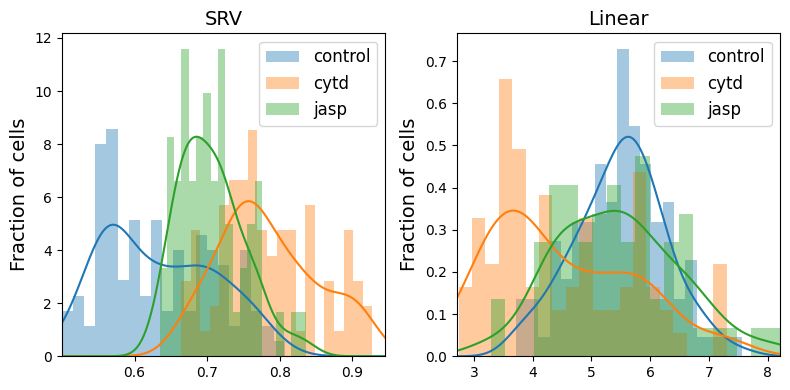

In [40]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)
    
    for i, treatment in enumerate(TREATMENTS):
        distances = dists_to_global_mean[metric][treatment][line][~gs.isnan(dists_to_global_mean[metric][treatment][line])]
        
        
        axs[j].hist(distances, bins=20, alpha=0.4, density=True, label=treatment, color=f"C{i}")
        kde = stats.gaussian_kde(distances)
        axs[j].plot(xx, kde(xx), color=f"C{i}")
        axs[j].set_xlim((min_dists, max_dists))
        axs[j].legend(fontsize=12)

        axs[j].set_title(f"{metric}", fontsize=14)
        axs[j].set_ylabel("Fraction of cells", fontsize=14)


# fig.suptitle("Histograms of SRV distances to global mean cell", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_histogram.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_histogram.pdf"))


control SRV
counts are: [0.51397439 1.28493597 4.11179511 4.11179511 5.13974388 4.3687823
 2.56987194 2.05589755 1.28493597 0.51397439 0.77096158 2.82685914
 2.56987194 4.11179511 4.11179511 3.59782072 2.82685914 2.82685914
 1.02794878 1.28493597]
bin_edges are: [0.5099013  0.52916489 0.54842848 0.56769206 0.58695565 0.60621924
 0.62548282 0.64474641 0.66401    0.68327358 0.70253717 0.72180076
 0.74106434 0.76032793 0.77959151 0.7988551  0.81811869 0.83738227
 0.85664586 0.87590945 0.89517303]
cytd SRV
counts are: [0.61978119 0.         0.         0.         0.         0.
 0.61978119 0.         0.         1.85934357 1.85934357 2.47912476
 2.47912476 4.95824953 6.19781191 9.29671786 8.67693667 7.43737429
 6.19781191 4.95824953]
bin_edges are: [0.59833051 0.61567968 0.63302884 0.65037801 0.66772718 0.68507635
 0.70242552 0.71977468 0.73712385 0.75447302 0.77182219 0.78917136
 0.80652053 0.82386969 0.84121886 0.85856803 0.8759172  0.89326637
 0.91061554 0.9279647  0.94531387]
jasp SRV
cou

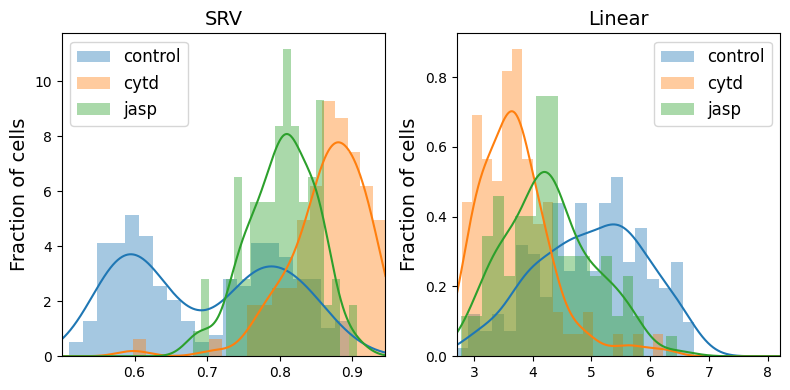

In [41]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

line = 'dunn'
for j, metric in enumerate(METRICS):
    distances = []
    min_dists = min(dists_to_global_mean_list[metric])
    max_dists = max(dists_to_global_mean_list[metric])
    xx = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), k_sampling_points)
    
    for i, treatment in enumerate(TREATMENTS):
        distances = dists_to_global_mean[metric][treatment][line][~gs.isnan(dists_to_global_mean[metric][treatment][line])]
        counts, bin_edges, _ = axs[j].hist(distances, bins=20, alpha=0.4, density=True, label=treatment, color=f"C{i}")
        print(treatment, metric)
        print("counts are:", counts)
        print("bin_edges are:", bin_edges)
        kde = stats.gaussian_kde(distances)
        axs[j].plot(xx, kde(xx), color=f"C{i}")
        axs[j].set_xlim((min_dists, max_dists))
        axs[j].legend(fontsize=12)

        axs[j].set_title(f"{metric}", fontsize=14)
        axs[j].set_ylabel("Fraction of cells", fontsize=14)


# fig.suptitle("Histograms of SRV distances to global mean cell", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_histogram.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_histogram.pdf"))


Conduct T-test to test if the two samples have the same expected average

In [42]:
for line in LINES:
    for i in range(len(TREATMENTS)):
        tmt1 = TREATMENTS[i]
        for j in range(i+1, len(TREATMENTS)):
            tmt2 = TREATMENTS[j]
            for metric in METRICS:
                distance1 = dists_to_global_mean[metric][tmt1][line][~gs.isnan(dists_to_global_mean[metric][tmt1][line])]
                distance2 = dists_to_global_mean[metric][tmt2][line][~gs.isnan(dists_to_global_mean[metric][tmt2][line])]
                t_statistic, p_value = stats.ttest_ind(distance1, distance2)
                print(f"Significance of differences for {line} between {tmt1} and {tmt2} using {metric} metric is: {'%.2e' % Decimal(p_value)}")

Significance of differences for dlm8 between control and cytd using SRV metric is: 2.37e-31
Significance of differences for dlm8 between control and cytd using Linear metric is: 5.87e-11
Significance of differences for dlm8 between control and jasp using SRV metric is: 3.27e-10
Significance of differences for dlm8 between control and jasp using Linear metric is: 7.56e-01
Significance of differences for dlm8 between cytd and jasp using SRV metric is: 1.67e-12
Significance of differences for dlm8 between cytd and jasp using Linear metric is: 3.29e-06
Significance of differences for dunn between control and cytd using SRV metric is: 8.42e-36
Significance of differences for dunn between control and cytd using Linear metric is: 1.38e-27
Significance of differences for dunn between control and jasp using SRV metric is: 3.87e-18
Significance of differences for dunn between control and jasp using Linear metric is: 4.30e-10
Significance of differences for dunn between cytd and jasp using SRV me

Let's analyze bi-modal distribution for the control group of dunn cell line using SRV metric

We consider two groups: cells with [0.56870938, 0.58850988) - distance to the mean, cells with [0.84591638, 0.86571688) distance to the mean, and find the modes of the two groups

0.5099013036107223 0.8951730340033417
[22, 26, 27, 29, 30, 39, 40, 51, 54, 58, 112, 114, 124, 130, 141, 159]
[15, 19, 162, 169, 180, 200, 201]


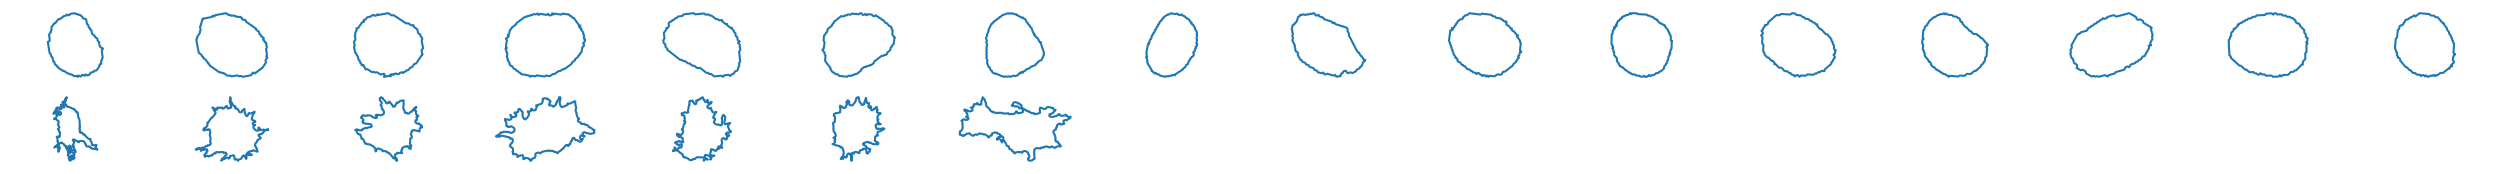

In [43]:
line = 'dunn'
treatment = 'control'
metric = 'SRV'
distances = dists_to_global_mean[metric][treatment][line]
print(min(distances), max(distances))
group_1_left = 0.56870938
group_1_right = 0.58850988
group_2_left = 0.84591638
group_2_right = 0.86571688
group_1_indices = [i for i, element in enumerate(distances) if element <= group_1_right and element > group_1_left]
group_2_indices = [i for i, element in enumerate(distances) if element <= group_2_right and element > group_2_left]
print(group_1_indices)
print(group_2_indices)
group_1_cells = gs.array(ds_align[metric][treatment][line])[group_1_indices,:,:]
group_2_cells = gs.array(ds_align[metric][treatment][line])[group_2_indices,:,:]

col_num = max(len(group_1_indices), len(group_2_indices))
fig = plt.figure(figsize=(2*col_num, 2))
count = 1
for index in range(len(group_1_indices)):
    cell = group_1_cells[index]
    fig.add_subplot(2, col_num, count)
    count += 1
    plt.plot(cell[:, 0], cell[:, 1])
    plt.axis("equal")
    plt.axis("off")

count = max(len(group_1_indices), len(group_2_indices))+1
for index in range(len(group_2_indices)):
    cell = group_2_cells[index]
    fig.add_subplot(2, col_num, count)
    count += 1
    plt.plot(cell[:, 0], cell[:, 1])
    plt.axis("equal")
    plt.axis("off")

plt.savefig(os.path.join(figs_dir, f"{line}_bimodal_mean.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_bimodal_mean.pdf"))

# Visualization of the Mean of each Treatment

The mean distances to the global mean shape differ. We also plot the mean shape for each of the subgroup, to get intuition on how the mean shape of each subgroup looks like.

We first calculate the SRV mean

In [44]:
mean_treatment_cells = {}
metric = 'SRV'
for treatment in TREATMENTS:
    treatment_cells = []
    for line in LINES:
        treatment_cells.extend(ds_align[metric][treatment][line])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(CURVES_SPACE_SRV.projection(gs.array(treatment_cells)))
    mean_treatment_cells[treatment] = mean_estimator.estimate_

In [45]:
mean_line_cells = {}
for line in LINES:
    line_cells = []
    for treatment in TREATMENTS:
        line_cells.extend(ds_align[metric][treatment][line])
    mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
    mean_estimator.fit(CURVES_SPACE_SRV.projection(gs.array(line_cells)))
    mean_line_cells[line] = mean_estimator.estimate_

In [46]:
mean_cells = {}
metric = 'SRV'
mean_cells[metric] = {}
for treatment in TREATMENTS:
    mean_cells[metric][treatment] = {}
    for line in LINES:
        mean_estimator = FrechetMean(space=CURVES_SPACE_SRV)
        mean_estimator.fit(CURVES_SPACE_SRV.projection(gs.array(ds_align[metric][treatment][line])))
        mean_cells[metric][treatment][line] = mean_estimator.estimate_

We then calculate the linear mean

In [47]:
metric = 'Linear'
mean_cells[metric] = {}
for treatment in TREATMENTS:
    mean_cells[metric][treatment] = {}
    for line in LINES:
        mean_cells[metric][treatment][line] = gs.mean(ds_align[metric][treatment][line], axis=0)

While the mean shapes of the control groups (for both cell lines) look regular, we observe that:
- the mean shape for cytd is the most irregular (for both cell lines)
- while the mean shape for jasp is more elongated for dlm8 cell line, and more irregular for dunn cell line.

# Distance of the Cell Shapes to their Own Mean Shape

Lastly, we evaluate how each subgroup of cell shapes is distributed around the mean shape of their specific subgroup.

In [48]:
dists_to_own_mean = {}

for metric in METRICS:
    dists_to_own_mean[metric] = {}
    for treatment in TREATMENTS:
        dists_to_own_mean[metric][treatment] = {}
        for line in LINES:
            dists = []
            ids = []
            for i_curve, curve in enumerate(ds_align[metric][treatment][line]):
                if metric == 'SRV':
                    one_dist = CURVES_SPACE_SRV.metric.dist(curve, mean_cells[metric][treatment][line])
                else:
                    one_dist = gs.linalg.norm(curve - mean_cells[metric][treatment][line])
                if ~gs.isnan(one_dist):
                    dists.append(one_dist)
                else:
                    ids.append(i_curve)
            dists_to_own_mean[metric][treatment][line] = dists


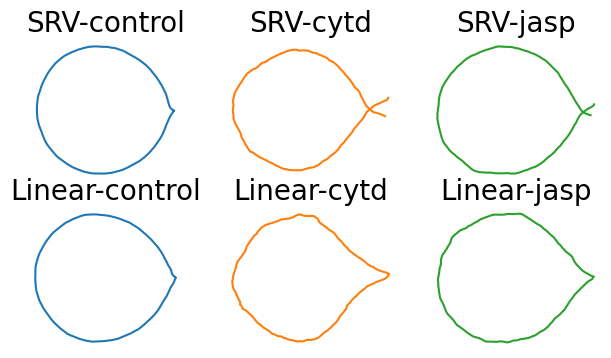

In [49]:
line = 'dunn'

fig, axes = plt.subplots(
    ncols=len(TREATMENTS),
    nrows=len(METRICS),
    figsize=(2.5*len(TREATMENTS), 2*len(METRICS)))

for j, metric in enumerate(METRICS):
    for i, treatment in enumerate(TREATMENTS):
        ax = axes[j, i]
        mean_cell = mean_cells[metric][treatment][line]
        ax.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{i}")
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(f"{metric}-{treatment}", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.pdf"))

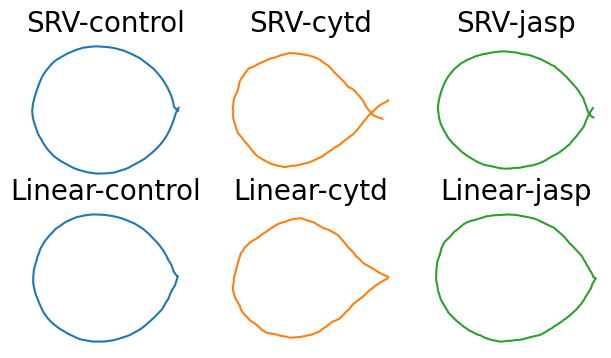

In [50]:
line = 'dlm8'

fig, axes = plt.subplots(
    ncols=len(TREATMENTS),
    nrows=len(METRICS),
    figsize=(2.5*len(TREATMENTS), 2*len(METRICS)))

for j, metric in enumerate(METRICS):
    for i, treatment in enumerate(TREATMENTS):
        ax = axes[j, i]
        mean_cell = mean_cells[metric][treatment][line]
        ax.plot(mean_cell[:, 0], mean_cell[:, 1], color=f"C{i}")
        ax.axis("equal")
        ax.axis("off")
        ax.set_title(f"{metric}-{treatment}", fontsize=20)
plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_own_mean.pdf"))

The above code find a given number of quantiles within the distance's histogram, using SRV metric and own mean, and plots the corresponding cell, for each treatment and each cell line.

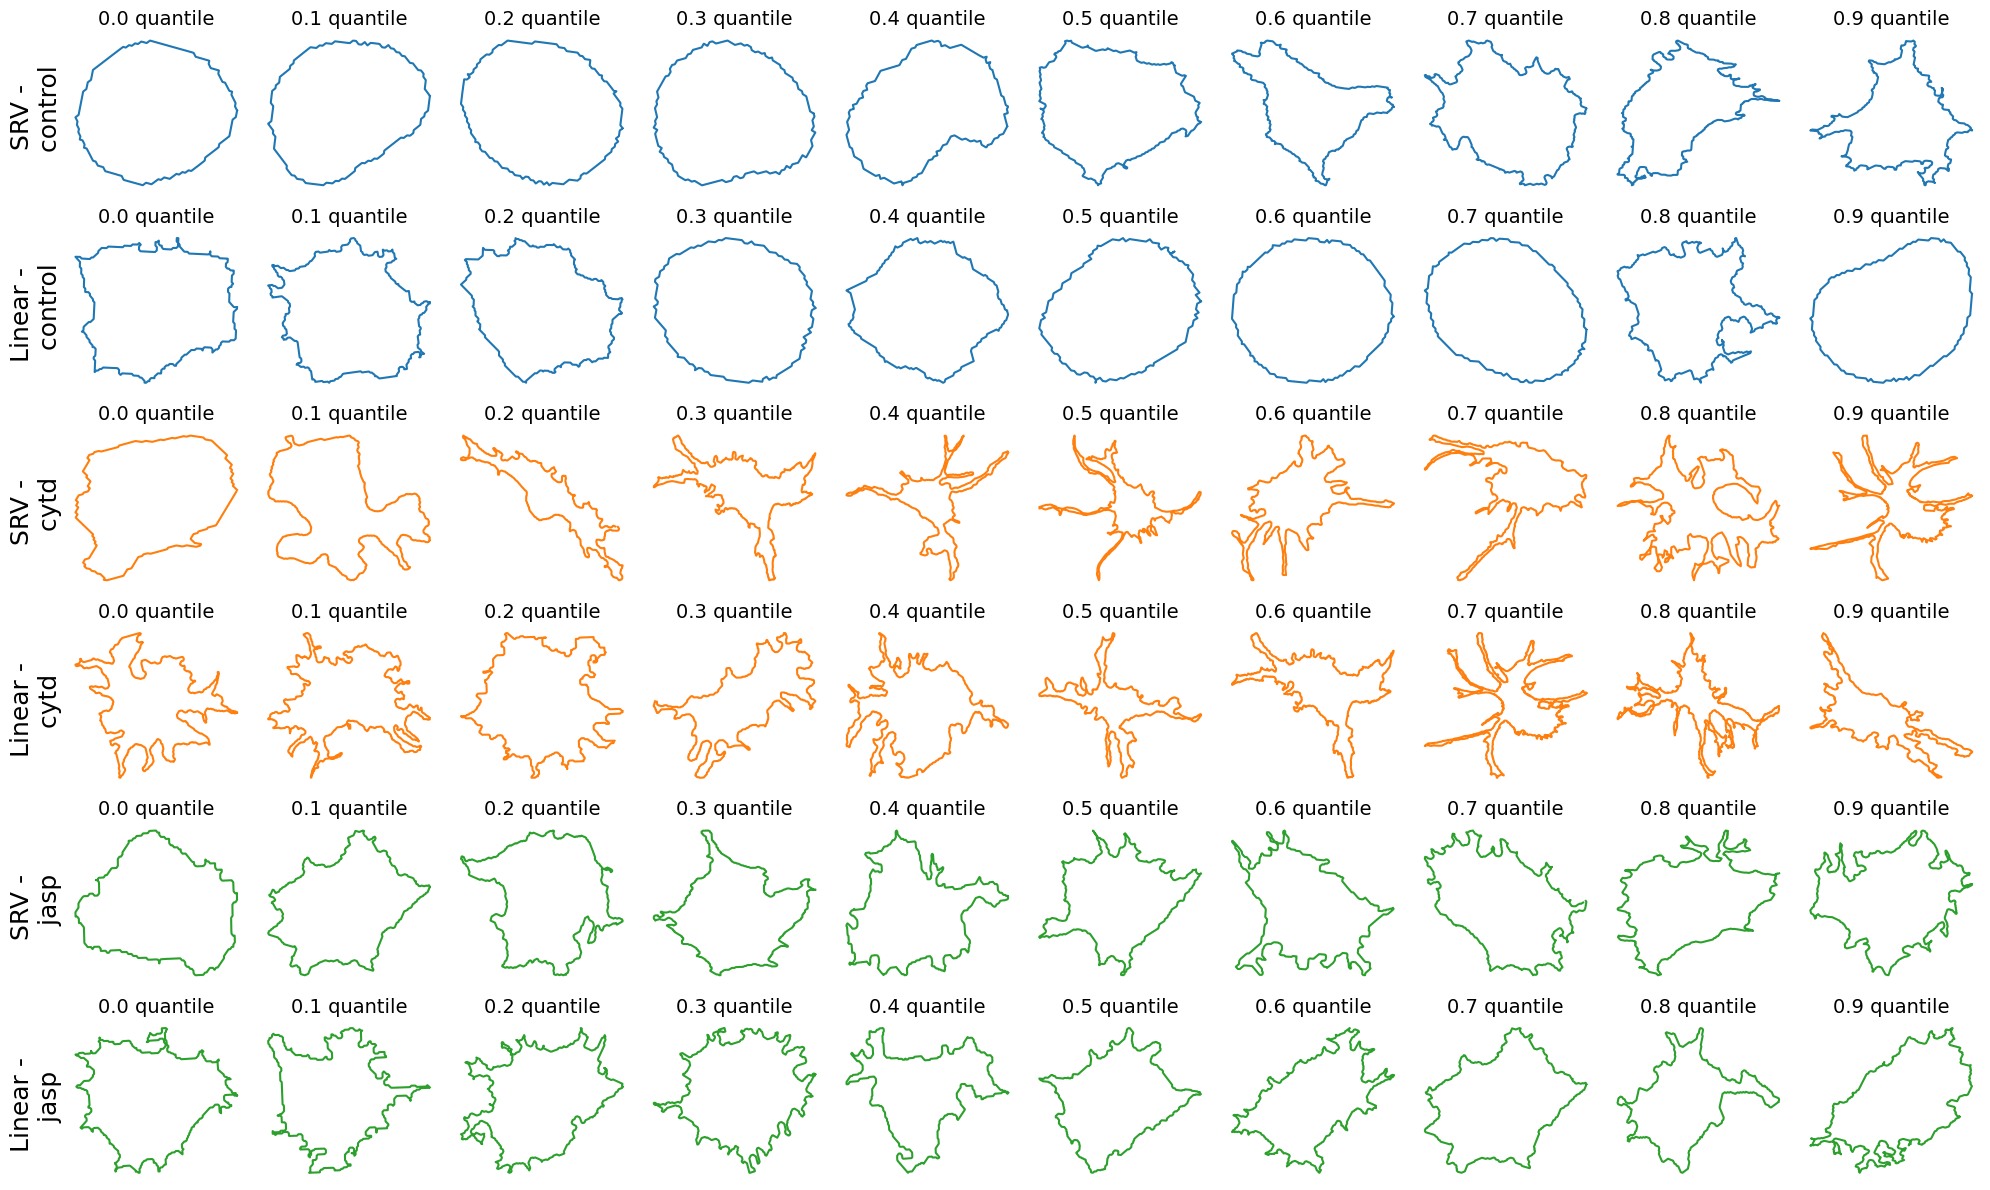

In [51]:
import scipy.stats as ss

line = 'dunn'
n_quantiles = 10

fig, axes = plt.subplots(
    nrows=len(TREATMENTS)*len(METRICS),
    ncols=n_quantiles,
    figsize=(20, 2 * len(TREATMENTS) * len(METRICS)),
)

ranks = {}

for i, treatment in enumerate(TREATMENTS):
    ranks[treatment] = {}
    for j, metric in enumerate(METRICS):
        
        dists_list = dists_to_own_mean[metric][treatment][line]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[metric][treatment][line])
        assert len(dists_list) == len(cells_list)
        n_cells = len(dists_list)

        ranks[treatment][metric] = ss.rankdata(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2*i+j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{i}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{metric} - \n {treatment}", rotation=90, fontsize=18)
plt.tight_layout()
# plt.suptitle(f"Quantiles for linear metric using own mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, f"{line}_quantile.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_quantile.pdf"))


Plot rank data

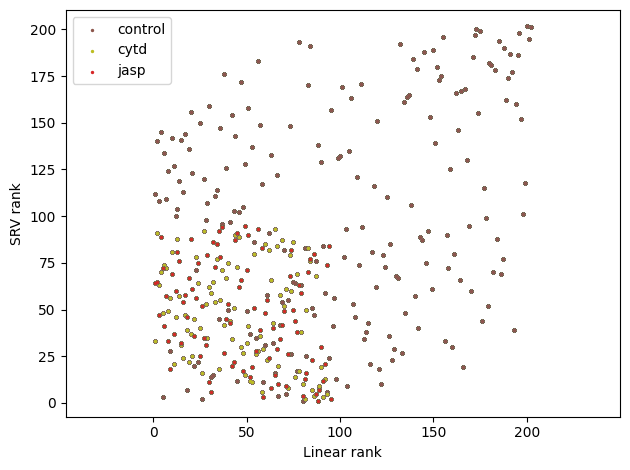

In [52]:
from collections import OrderedDict


for treatment in treatments:
    plt.scatter(ranks[treatment]['Linear'], ranks[treatment]['SRV'], s=2, label=treatment)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.xlabel('Linear rank')
plt.ylabel('SRV rank')

plt.legend(by_label.values(), by_label.keys())
plt.axis("equal")
plt.tight_layout()

We do not observe any clear patterns between the rank of the cells with distances using SRV metric and with the linear metric.

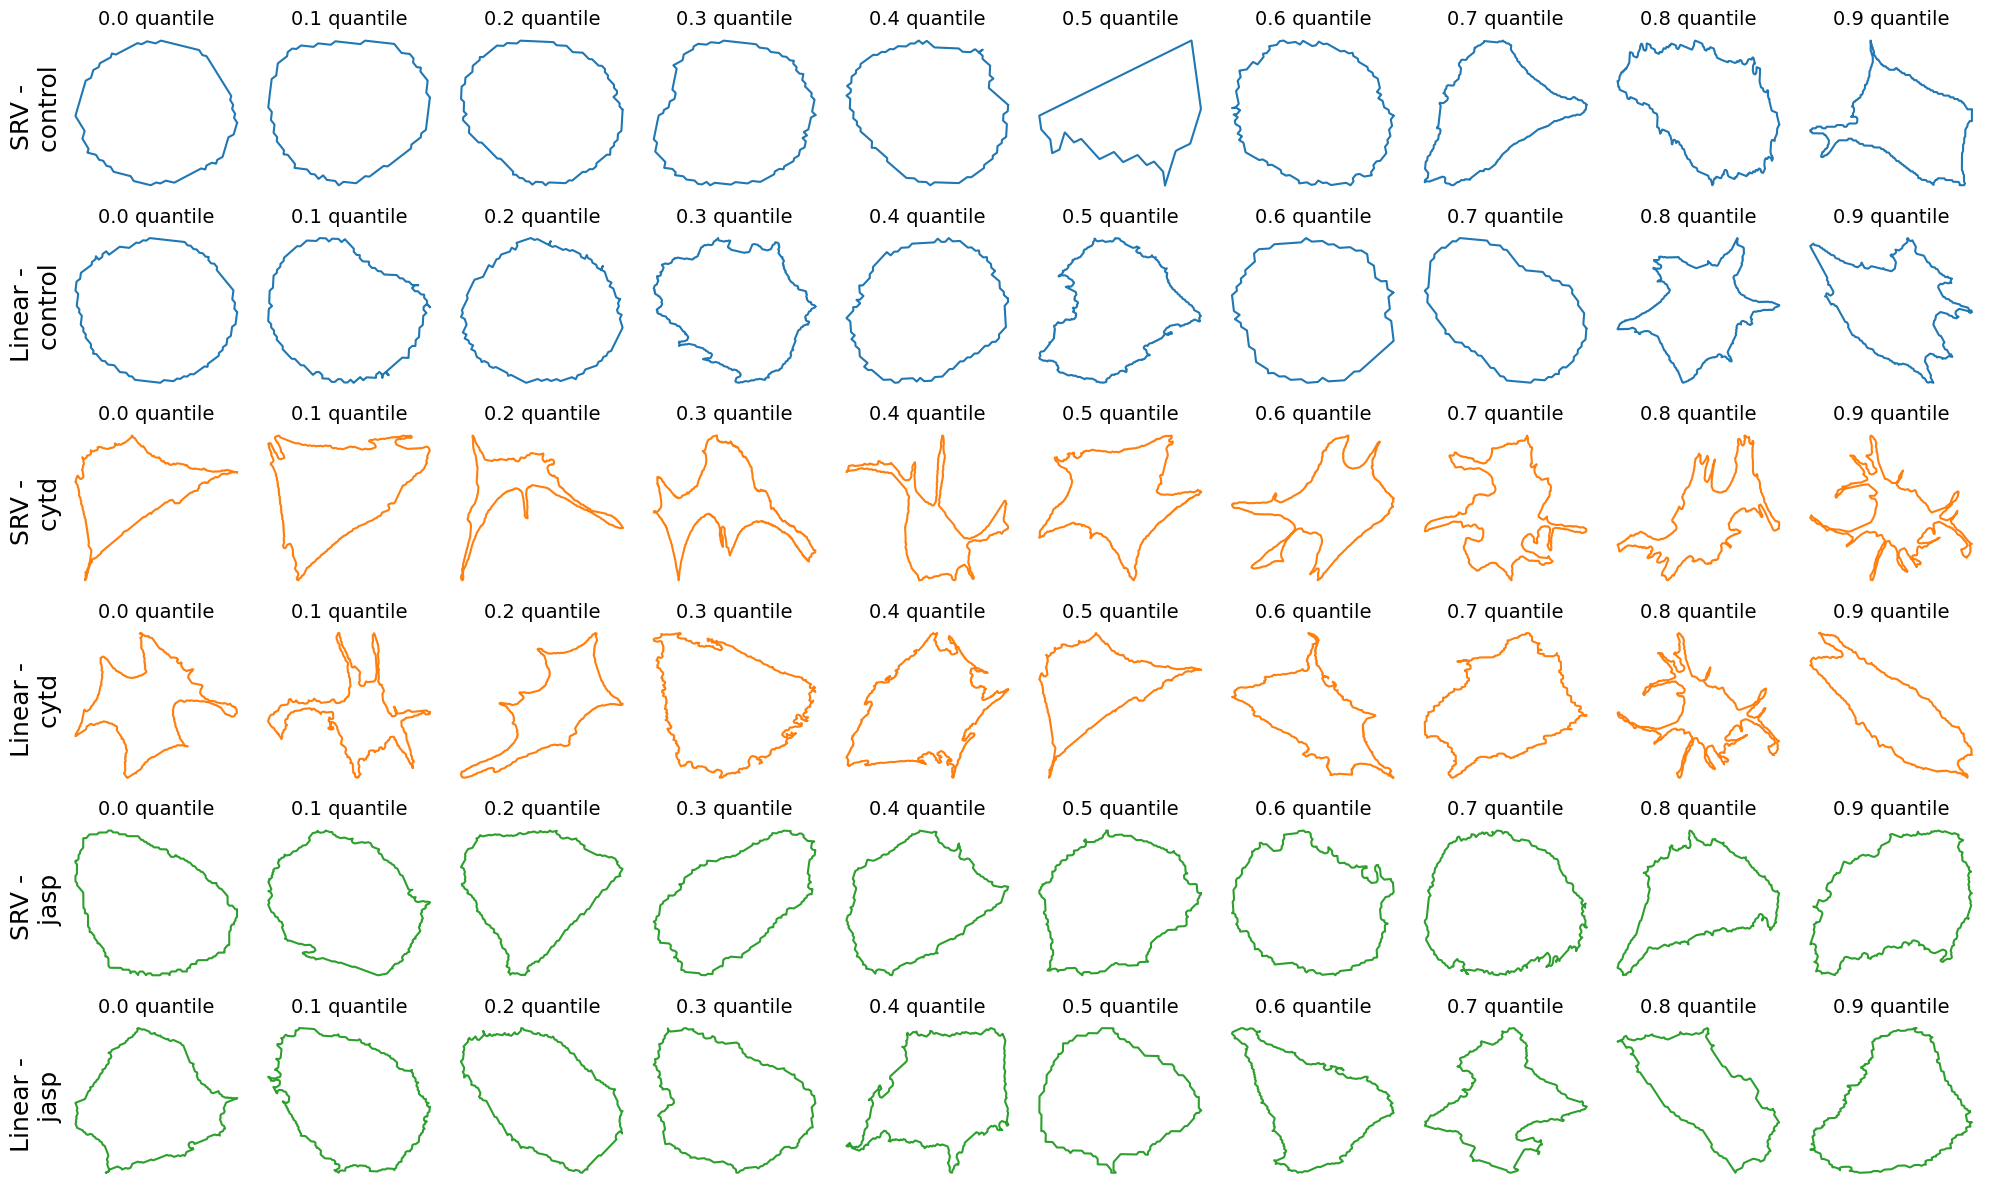

In [53]:
line = 'dlm8'
n_quantiles = 10

fig, axes = plt.subplots(
    nrows=len(TREATMENTS)*len(METRICS),
    ncols=n_quantiles,
    figsize=(20, 2 * len(TREATMENTS) * len(METRICS)),
)

for i, treatment in enumerate(TREATMENTS):
    for j, metric in enumerate(METRICS):
        dists_list = dists_to_own_mean[metric][treatment][line]
        dists_list = [d + 0.0001 * gs.random.rand(1)[0] for d in dists_list]
        cells_list = list(ds_align[metric][treatment][line])
        assert len(dists_list) == len(dists_list)
        n_cells = len(dists_list)

        zipped_lists = zip(dists_list, cells_list)
        sorted_pairs = sorted(zipped_lists)

        tuples = zip(*sorted_pairs)
        sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
        for i_quantile in range(n_quantiles):
            quantile = int(0.1 * n_cells * i_quantile)
            one_cell = sorted_cells_list[quantile]
            ax = axes[2*i+j, i_quantile]
            ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{i}")
            ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
            # ax.axis("off")
            # Turn off tick labels
            ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["bottom"].set_visible(False)
            ax.spines["left"].set_visible(False)
            if i_quantile == 0:
                ax.set_ylabel(f"{metric} - \n {treatment}", rotation=90, fontsize=18)
plt.tight_layout()
# plt.suptitle(f"Quantiles for linear metric using own mean", y=-0.01, fontsize=24)
plt.savefig(os.path.join(figs_dir, f"{line}_quantile.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_quantile.pdf"))


The above code find a given number of quantiles within the distance's histogram, using linear metric and own mean, and plots the corresponding cell, for each treatment and each cell line.

# Dimensionality Reduction

We use the following experiments to illustrate how SRV metric can help with dimensionality reduction 

In [54]:
def scaled_stress(pos, pairwise_dists):
    """ 
    Calculate the scaled stress invariant to scaling using the original stress \
    statistics and actual pairwise distances

    :param float unscaled_stress: the original stress
    :param 2D np.array[float] pairwise_dists: pairwise distance
    """
    
    # compute pairwise distance of pos
    pairwise_pos = np.empty(shape=(pos.shape[0], pos.shape[0]))
    for i in range(pos.shape[0]):
        for j in range(pos.shape[0]):
            pairwise_pos[i,j] = np.sqrt(np.sum(pos[i]-pos[j])**2)
    
    print(pairwise_pos)
    stress = np.sqrt(np.sum((pairwise_dists-pairwise_pos)**2))
    
    return stress/np.sqrt(np.sum(pairwise_dists**2))

In [55]:
mds = {}
pos = {}
dims = range(2, 11)
stresses = {}

for metric in METRICS:
    mds[metric] = {}
    pos[metric] = {}
    stresses[metric] = []
    for dim in dims:
        # eps = 1e-5
        # if metric == 'Linear':
        #     eps = 1e-3
        mds[metric][dim] = manifold.MDS(n_components=dim, random_state=10, dissimilarity="precomputed") # random_state set to 10
        pos[metric][dim] = mds[metric][dim].fit(pairwise_dists[metric]).embedding_
        stress_val = mds[metric][dim].stress_
        scaled_stress_val = np.sqrt(stress_val/((pairwise_dists[metric]**2).sum()/2))
        # scaled_stress_val = scaled_stress(pos[metric][dim], pairwise_dists[metric])

        print(f"the unscaled stress for {metric} model is for {dim}:", stress_val)
        stresses[metric].append(scaled_stress_val)

the unscaled stress for SRV model is for 2: 0.007887881325126321
the unscaled stress for SRV model is for 3: 0.005119326021132178
the unscaled stress for SRV model is for 4: 0.0036615538985954633
the unscaled stress for SRV model is for 5: 0.0029299990883000717
the unscaled stress for SRV model is for 6: 0.0023860320525854327
the unscaled stress for SRV model is for 7: 0.0020168763727693166
the unscaled stress for SRV model is for 8: 0.0017501291026934755
the unscaled stress for SRV model is for 9: 0.0015409823253061021
the unscaled stress for SRV model is for 10: 0.0013841275338426127
the unscaled stress for Linear model is for 2: 0.023083491397833063
the unscaled stress for Linear model is for 3: 0.01463650322963472
the unscaled stress for Linear model is for 4: 0.012674483222488259
the unscaled stress for Linear model is for 5: 0.010776027298894255
the unscaled stress for Linear model is for 6: 0.009794505747052441
the unscaled stress for Linear model is for 7: 0.009556784472637737


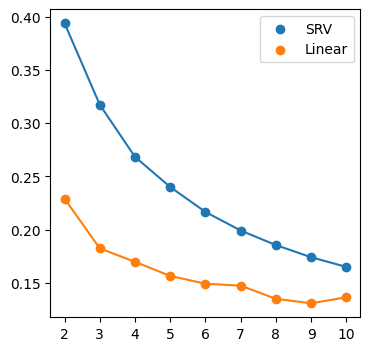

In [56]:
plt.figure(figsize = (4,4))
for metric in METRICS:
    plt.scatter(dims, stresses[metric], label=metric)
    plt.plot(dims, stresses[metric])
plt.xticks(dims)
plt.legend()
plt.savefig(os.path.join(figs_dir, f"MDS_stress.svg"))
plt.savefig(os.path.join(figs_dir, f"MDS_stress.pdf"))

In terms of the scaled stress statistics, we observe linear metric perform better than SRV metric. That is, linear metric preserves the pairwise distances in embedded dimension better than the SRV metric.

Calculate MDS statistics for dimension 2

In [57]:
metric = 'SRV'
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_

MDS embedding of cell treatments (control, cytd and jasp) for different cell lines (dunn and dlm8)

In [58]:
embs = {}
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[metric][treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

We draw a comparison with linear metric using the following code

In [59]:
metric = 'Linear'
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_
print("the stress for linear model is:", mds.stress_)


the stress for linear model is: 0.022178860584726904


In [60]:
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[metric][treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

The stress for MDS embedding using the linear metric is better than SRV metric. 

However, if we can make a better interpretation of the visual result of SRV metric, we could still argue SRV is better at capturing cell heterogeneity. 

In [61]:
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[metric][treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

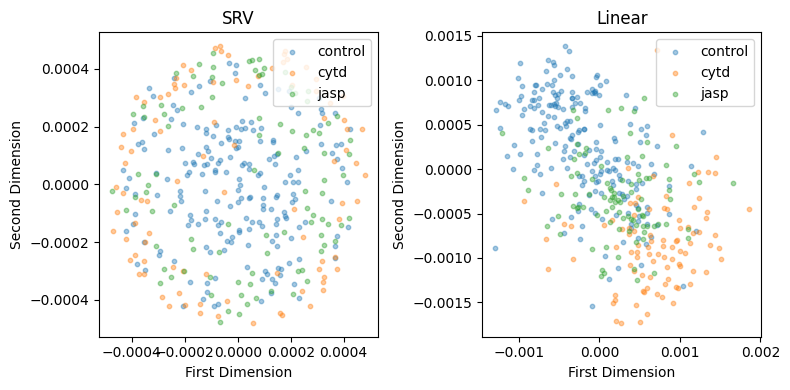

In [62]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

line = 'dunn'
for j, metric in enumerate(METRICS):
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using SRV metric", fontsize=20)

plt.tight_layout()

plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D.pdf"))


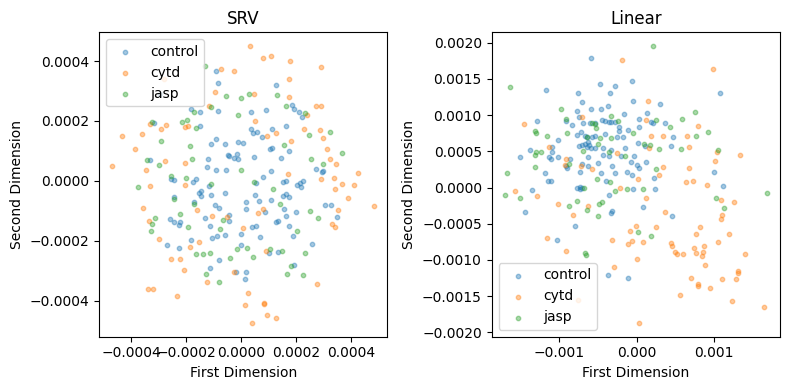

In [63]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4))

line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using SRV metric", fontsize=20)

plt.tight_layout()

plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_2D.pdf"))


We also consider embedding in 3D. 

In [64]:
metric = 'SRV'
mds = manifold.MDS(n_components=3, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_


In [65]:
embs = {}
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[metric][treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

In [66]:
metric = 'Linear'
mds = manifold.MDS(n_components=3, random_state=1, dissimilarity="precomputed")
pos = mds.fit(pairwise_dists[metric]).embedding_
print("the stress for linear model is:", mds.stress_)


the stress for linear model is: 0.014931497779013153


In [67]:
embs[metric] = {}
index = 0
for treatment in TREATMENTS:
    embs[metric][treatment] = {}
    for line in LINES:
        cell_num = len(ds_align[metric][treatment][line])   
        embs[metric][treatment][line] = pos[index:index+cell_num]
        index += cell_num

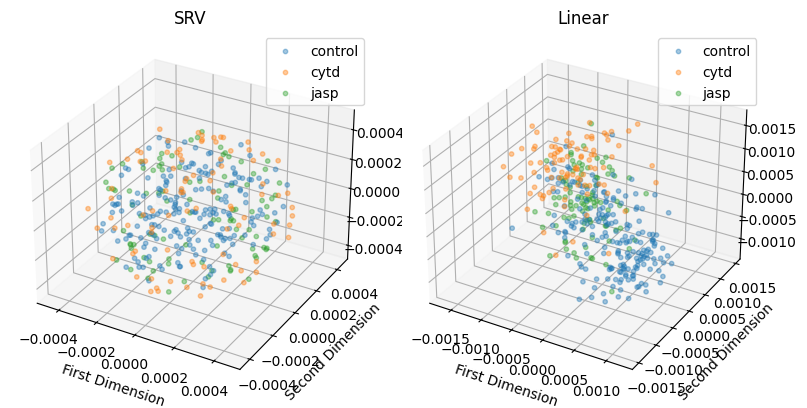

In [68]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4), subplot_kw=dict(projection='3d'))

line = 'dunn'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                cur_embs[:, 2],
                label=treatment,
                s=10,
                alpha=0.4
            )
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using linear metric", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D.pdf"))


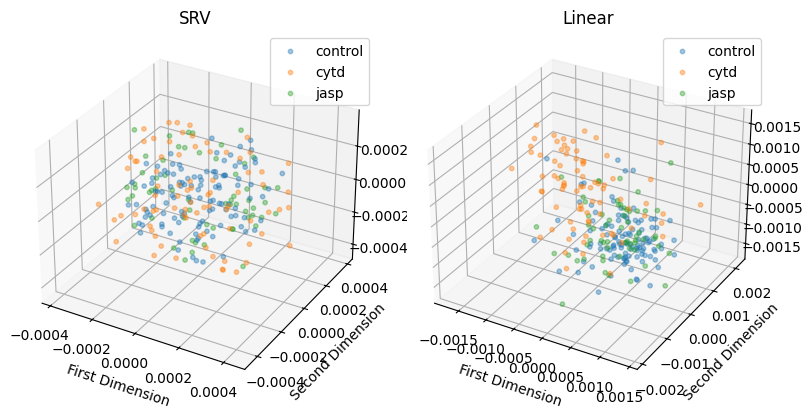

In [69]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True, figsize=(8, 4), subplot_kw=dict(projection='3d'))

line = 'dlm8'
for j, metric in enumerate(METRICS):
    distances = []
    for i, treatment in enumerate(TREATMENTS):
        cur_embs = embs[metric][treatment][line]
        axs[j].scatter(
                cur_embs[:, 0],
                cur_embs[:, 1],
                cur_embs[:, 2],
                label=treatment,
                s=10,
                alpha=0.4
            )
        # axs[j].set_xlim(-3.5*1e-5, 3.5*1e-5)
        axs[j].set_xlabel("First Dimension")
        axs[j].set_ylabel("Second Dimension")
        axs[j].legend()
        axs[j].set_title(f"{metric}")
# fig.suptitle("MDS of cell shapes using linear metric", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D.svg"))
plt.savefig(os.path.join(figs_dir, f"{line}_MDS_3D.pdf"))


# Multi-class (3-class) classification 

We now consider one cell line at the same time, to investigate the effects of the drugs on the cell shapes. Applying the MDS again gives the following results:

Since the detected subspace dimension for this dataset is 3, we perform the classification based on 3D embeddings.

In [70]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def svm_5_fold_classification(X, y):
    # Initialize a Support Vector Classifier
    svm_classifier = svm.SVC(kernel='poly', degree=4)

    # Prepare to split the data into 5 folds, maintaining the percentage of samples for each class
    skf = StratifiedKFold(n_splits=5)
    
    # To store precision and recall per class for each fold
    precisions_per_class = []
    recalls_per_class = []
    accuracy_per_class = []

    # Perform 5-fold cross-validation
    for train_index, test_index in skf.split(X, y):
        # Splitting data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        svm_classifier.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred = svm_classifier.predict(X_test)

        # Calculate precision and recall per class
        precision = precision_score(y_test, y_pred, average=None, zero_division=np.nan)
        recall = recall_score(y_test, y_pred, average=None, zero_division=np.nan)
        accuracy = accuracy_score(y_test, y_pred)

        # Store results from each fold
        precisions_per_class.append(precision)
        recalls_per_class.append(recall)
        accuracy_per_class.append(accuracy)
    
    # Calculate the mean precision and recall per class across all folds
    mean_precisions = np.mean(precisions_per_class, axis=0)
    mean_recalls = np.mean(recalls_per_class, axis=0)
    mean_accuracies = np.mean(accuracy_per_class, axis=0)

    np.set_printoptions(precision=2)
    
    print("Mean precisions per class across all folds:", round(np.mean(mean_precisions), 2))
    print("Mean recalls per class across all folds:", round(np.mean(mean_recalls), 2))
    print("Mean accuracies per class across all folds:", round(mean_accuracies, 2))

    return mean_precisions, mean_recalls

In [71]:
lines = gs.array(lines)
treatments = gs.array(treatments)

In [73]:
for line in LINES:
    for metric in METRICS:
        control_indexes = gs.where((lines == line) & (treatments == "control"))[0]
        cytd_indexes = gs.where((lines == line) & (treatments == "cytd"))[0]
        jasp_indexes = gs.where((lines == line) & (treatments == "jasp"))[0]
        treatment_indexes = gs.where((lines == line) & (treatments != 'control'))[0]

        # indexes = gs.concatenate((jasp_indexes, cytd_indexes, control_indexes))
        indexes = gs.concatenate((control_indexes, treatment_indexes))
        matrix = pairwise_dists[metric][indexes][:, indexes]

        mds = manifold.MDS(n_components=3, random_state = 10, dissimilarity="precomputed")
        pos = mds.fit(matrix).embedding_

        line_treatments = treatments[lines == line]
        line_treatments_strings, line_treatments_labels = np.unique(line_treatments, return_inverse=True)
        # print(line_treatments_strings)
        # print(line_treatments_labels)

        # for i, label in enumerate(line_treatments_labels):
        #     if line_treatments_strings[label] == 'cytd' or line_treatments_strings[label] == 'jasp':
        #         line_treatments_labels[i] = len(line_treatments_strings)
            

        print(f"Using {metric} on {line}")
        # print(line_treatments_labels)
        svm_5_fold_classification(pos, line_treatments_labels)


Using SRV on dlm8
Mean precisions per class across all folds: 0.37
Mean recalls per class across all folds: 0.42
Mean accuracies per class across all folds: 0.5
Using Linear on dlm8
Mean precisions per class across all folds: 0.42
Mean recalls per class across all folds: 0.44
Mean accuracies per class across all folds: 0.52
Using SRV on dunn
Mean precisions per class across all folds: 0.59
Mean recalls per class across all folds: 0.48
Mean accuracies per class across all folds: 0.58
Using Linear on dunn
Mean precisions per class across all folds: nan
Mean recalls per class across all folds: 0.34
Mean accuracies per class across all folds: 0.49
